In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import seaborn as sns
%matplotlib inline

In [57]:
grove = pd.read_csv("/Users/dennishou/Desktop/Grove_Analytics.csv")

grove.rename(columns={'Shipment Number':'Shipment_Number','Customer ID':'Customer_ID'
                     ,'Shipment Date':'Shipment_Date'
                     ,'Order Value':'Order_Value'
                     ,'Acquisition channel group':'Acquisition_channel_group'},inplace=True)
grove['Shipment_Date'] = pd.to_datetime(grove['Shipment_Date'])
grove['Shipment_Week'] = grove.Shipment_Date.apply(lambda x: x.strftime('%W'))
grove['Order_Value'] = grove[grove.columns[3]].replace('[\$,]', '', regex=True).astype(float)


In [58]:
grove.set_index('Customer_ID', inplace=True)

grove['First_Shipment_Week'] = grove.groupby(level=0)['Shipment_Date'].min().apply(lambda x: x.strftime('%W'))

grove.reset_index(inplace=True)

grove.head()

,Customer_ID,Shipment_Number,Shipment_Date,Order_Value,Acquisition_channel_group,Shipment_Week,First_Shipment_Week
0,17190313,1,2018-06-01,37.50,1.0,22,22
1,17246417,1,2018-06-01,26.11,2.0,22,22
2,16481211,1,2018-06-01,21.86,3.0,22,22
3,17211589,2,2018-07-03,30.89,2.0,27,22
4,17211589,3,2018-09-08,230.88,2.0,36,22


In [82]:
grouped = grove.groupby(['First_Shipment_Week', 'Shipment_Week'])
cohorts = grouped.agg({'Customer_ID': pd.Series.nunique,
                       'Order_Value': np.sum})

cohorts.rename(columns={'Customer_ID': 'TotalCustomers',
                        'Order_Value': 'Revenue'}, inplace=True)



In [81]:
def cohort_period(grove):

    grove['CohortPeriod'] = np.arange(len(grove)) + 1
    return grove

cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [80]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['First_Shipment_Week', 'CohortPeriod'], inplace=True)
cohort_group_size = cohorts['TotalCustomers'].groupby(level=0).first()


In [83]:
cohorts['TotalCustomers'].unstack(0).head(10)

First_Shipment_Week,22,23,24,25,26
Shipment_Week,,,,,
22,2484.0,NaN,NaN,NaN,NaN
23,48.0,6660.0,NaN,NaN,NaN
24,47.0,119.0,8609.0,NaN,NaN
25,93.0,131.0,141.0,7643.0,NaN
26,152.0,311.0,163.0,138.0,8458.0
27,723.0,1613.0,444.0,148.0,137.0
28,111.0,830.0,2167.0,458.0,181.0
29,101.0,217.0,931.0,1715.0,458.0
30,146.0,278.0,353.0,943.0,1755.0


In [77]:
user_retention = cohorts['TotalCustomers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

First_Shipment_Week,22,23,24,25,26
CohortPeriod,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.019324,0.017868,0.016378,0.018056,0.016198
3,0.018921,0.019670,0.018934,0.019364,0.021400
4,0.037440,0.046697,0.051574,0.059924,0.054150
5,0.061192,0.242192,0.251713,0.224388,0.207496
6,0.291063,0.124625,0.108143,0.123381,0.143296
7,0.044686,0.032583,0.041004,0.041214,0.031686
8,0.040660,0.041742,0.057846,0.045663,0.040672
9,0.058776,0.129129,0.126844,0.150072,0.134074


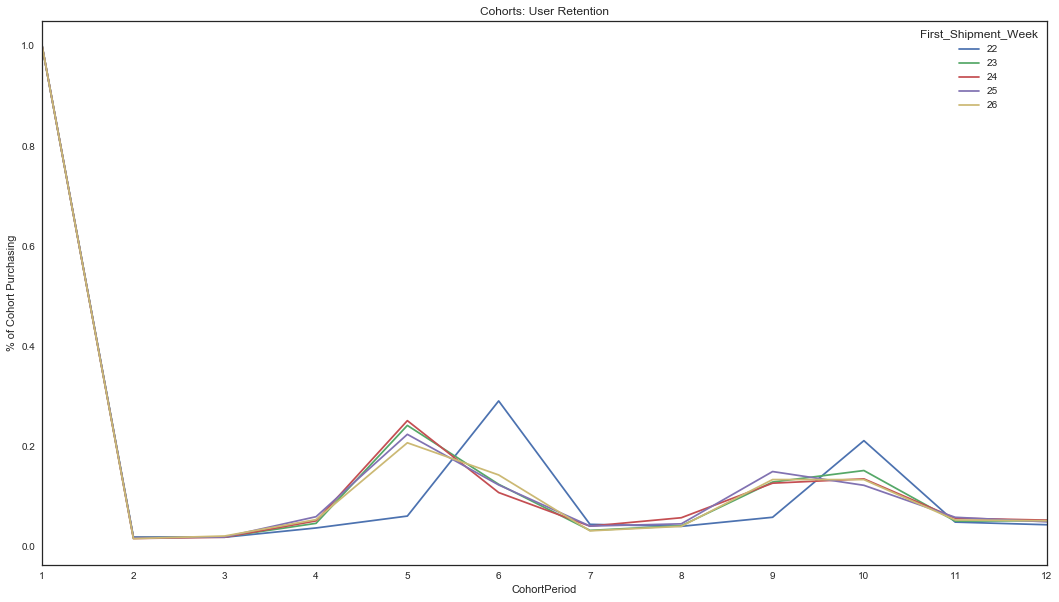

In [78]:
user_retention.plot(figsize=(18,10))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

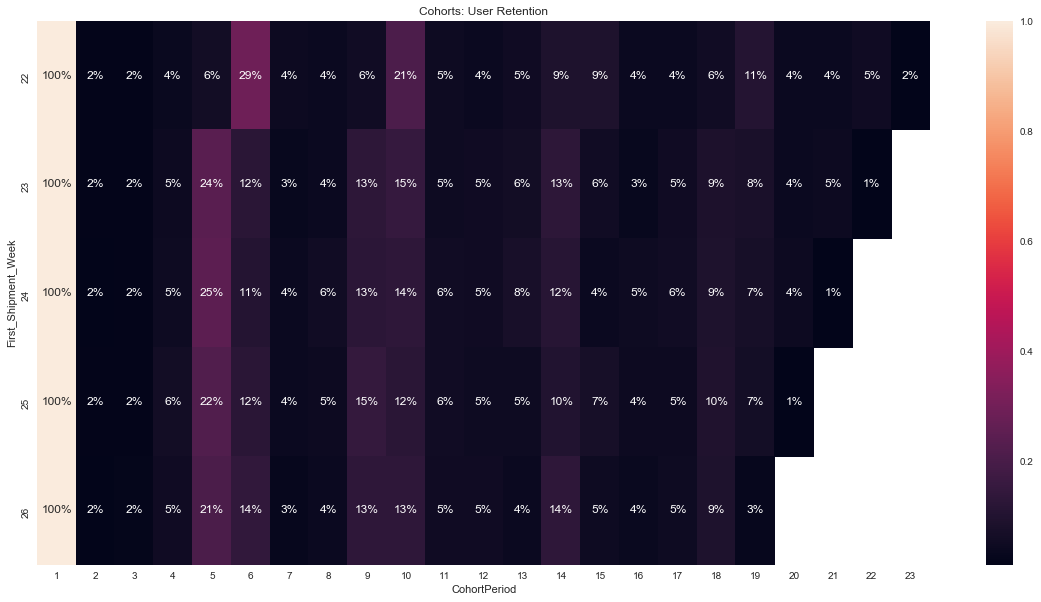

In [79]:
sns.set(style='white')

plt.figure(figsize=(20, 10))
plt.title('Cohorts: User Retention')

sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');